# 3DeeCellTracker Demo: Train StarDist3D

This notebook demonstrates how to train a StarDist3D model for cell segmentation. It is a revised version of a notebook originally from the StarDist project (URL: https://github.com/stardist/stardist/blob/master/examples/3D/2_training.ipynb), which includes programs based on a wrapper written by Chentao Wen for the StarDist package.

The demo data used in this notebook can be found in the "worm1_stardist_training_data" folder, which can be downloaded from https://osf.io/pgr95/."

**The basic procedures:**
- A. Import packages
- B. Load training data
- C. Configure StarDist3D model
- D. Check data augmentation
- E. Train StarDist3D
- F. Optimize a threshold for segmentation
- G. Confirm the segmentation results with trainied model

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

## A. Import packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import CellTracker.stardistwrapper as sdw

/tmp/ipykernel_2179383/3320912416.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## B. Load training data
This code block is used to load raw images and the corresponding cell annotations for training the StarDist model.

### Parameters
- `path_train_images`: A string specifying the file path to the raw images.
- `path_train_labels`: A string specifying the file path to the annotated label images (where each cell has a different label).

### Notes
>To specify the file paths for the training images and labels, you need to provide a string that tells the program where to find the images and labels. This string should include a special pattern that matches all files with the extension .tif in the directories where the images and labels are located. This pattern is called a Unix glob pattern and it looks like this: *.tif.

>For example, if your training images are located in a directory called "images" and your labels are located in a directory called "labels", you can specify the file paths like this:

```
    path_train_images = './images/*.tif'
    path_train_labels = './labels/*.tif'
```

>This tells the program to look for all files with the extension .tif in the "images" and "labels" directories.

>The "./" refers to the current working directory that contains this notebook.

>In addition, the training images and labels must be saved as 3D image stacks in .tif format, which is required by the "stardist" package used in this notebook. The corresponding image and label should have the same filename but in different directories. For example, if the image file is called "image001.tif", then the corresponding label file should also be called "image001.tif". You can check the downloaded demo data to see examples of how the images and labels are named.

100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.26it/s]


number of images:  20
- training:        17
- validation:       3
X[0].shape=(150, 400, 1404)


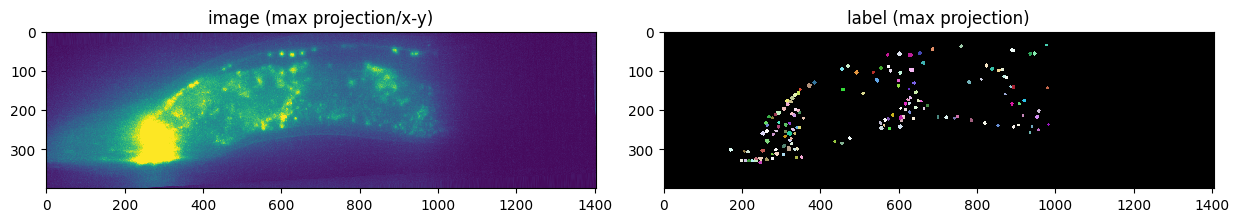

In [2]:
path_train_images = '/weka/scratch/weka/boydenlab/mansour8/package_dev/3DeeCellTracker/dataset/dataset_large/train_image/*.tif'
path_train_labels = '/weka/scratch/weka/boydenlab/mansour8/package_dev/3DeeCellTracker/dataset/dataset_large/train_label/*.tif'

X, Y, X_trn, Y_trn, X_val, Y_val, n_channel = \
    sdw.load_training_images(path_train_images, path_train_labels, max_projection=True)

## C. Configure StarDist3D model
This code block create a StarDist3D model for training.

### Parameters
- `model_name`: A string specifying the filename to save the trained StarDist3D model. This filename will be used to load the model later.

In [3]:
model_name="stardist_worm1"

model = sdw.configure(Y, n_channel, model_name=model_name)

empirical anisotropy of labeled objects = (1.0, 3.0, 3.0)
div_by=(8, 4, 4)
n_dim: 3
axes: ZYXC
n_channel_in: 1
n_channel_out: 97
train_checkpoint: weights_best.h5
train_checkpoint_last: weights_last.h5
train_checkpoint_epoch: weights_now.h5
n_rays: 96
grid: (2, 1, 1)
anisotropy: (1.0, 3.0, 3.0)
backbone: unet
rays_json: {'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.0, 3.0, 3.0)}}
n_classes: None
unet_n_depth: 2
unet_kernel_size: (3, 3, 3)
unet_n_filter_base: 32
unet_n_conv_per_depth: 2
unet_pool: (2, 2, 2)
unet_activation: relu
unet_last_activation: relu
unet_batch_norm: False
unet_dropout: 0.0
unet_prefix: 
net_conv_after_unet: 128
net_input_shape: (None, None, None, 1)
net_mask_shape: (None, None, None, 1)
train_patch_size: [144, 48, 48]
train_background_reg: 0.0001
train_foreground_only: 0.9
train_sample_cache: True
train_dist_loss: mae
train_loss_weights: (1, 0.2)
train_class_weights: (1, 1)
train_epochs: 400
train_steps_per_epoch: 100
train_learning_rate: 0.00

base_model.py (203): output path for model already exists, files may be overwritten: /weka/scratch/weka/boydenlab/mansour8/package_dev/3DeeCellTracker/Examples/ddsipim/stardist_models/stardist_worm1
2024-11-28 04:39:19.410765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 04:39:19.757298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79048 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:44:00.0, compute capability: 8.0


Using default values: prob_thresh=0.5, nms_thresh=0.4.


2024-11-28 04:39:24.145665: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-11-28 04:39:25.183305: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8700


median object size:      [27.  9.  9.]
network field of view :  [46 25 26]


## D. Check data augmentation
Data augmentation is used to create additional data that can improve the accuracy of the StarDist model. This code block displays some samples of the augmented images and labels for verification purposes. By checking the augmented data, you can ensure that the generated images and labels are reasonable.

In [ ]:
# plot some augmented examples
img, lbl = X[0],Y[0]
sdw.plot_img_label_max_projection(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = sdw.augmenter(img,lbl)
    sdw.plot_img_label_max_projection(img_aug, lbl_aug, img_title="image augmented (projection)", lbl_title="label augmented (projection)")

## E. Train StarDist3D

### Parameters
- `epochs`: An integer specifying the number of epochs for training. A larger number of epochs will require a longer training time. The default value of 500 is a reasonable choice.

In [ ]:
epochs=500

model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=sdw.augmenter, epochs=epochs)

## F. Threshold optimization
While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [ ]:
model.optimize_thresholds([X_val[0]], [Y_val[0]])

## G. Confirm the segmentation results with trainied model 
This code block is used to segment cells with the trained StarDist model. The first validation image is segmented and the results are displayed.

Note: If only one 3D image/label was provided for training in section B, the segmentation of this training image will be displayed.

In [ ]:
xx = X_val[0]
labels, details,prob_map = model.predict_instances_big(xx,'ZYX',block_size=(140,350,350),min_overlap=(22, 20, 20),context = 46)

effective: block_size=(144, 352, 352), min_overlap=(24, 20, 20), context=(48, 48, 48)
24 48 144 150
20 48 352 400
20 48 352 1404


  0%|                                                    | 0/24 [00:00<?, ?it/s]

BlockND(0|Z=000:144,Y=000:352,X=000:352)


2024-11-28 04:39:29.213499: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


In [ ]:
sdw.plot_img_label_max_projection(X_val[0],Y_val[0], lbl_title="label GT (projection)")
sdw.plot_img_label_max_projection(X_val[0],labels, lbl_title="label Pred (projection)")

In [ ]:
block_size=(140,250,250),min_overlap=(22, 20, 20),context = 46

In [ ]:
# slice volume for tracing

import os
import numpy as np
from tifffile import imread, imwrite

# Define input and output directories
input_dir = ""  # Replace with your input directory
output_dir = ""  # Replace with your output directory

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Loop through all 3D .tif files in the input directory
for filename in sorted(os.listdir(input_dir)):
    if filename.endswith(".tif"):
        # Extract volume number (assumes filenames like "3d_data_0001.tif")
        vol_number = filename.split('_')[-1].split('.')[0]
        
        # Load the 3D dataset
        volume = imread(os.path.join(input_dir, filename))
        
        # Save each slice of the volume as a separate 2D .tif file
        for z_idx in range(volume.shape[0]):  # Iterate over z-slices
            slice_filename = f"3d_data_t{vol_number}_{z_idx:04d}.tif"
            slice_path = os.path.join(output_dir, slice_filename)
            
            # Save the z-slice
            imwrite(slice_path, volume[z_idx])
            
        print(f"Processed volume {filename}, saved {volume.shape[0]} slices.")

print("All volumes have been processed and saved.")